# Module Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.transforms.functional import to_tensor, to_pil_image

from PIL import Image, ImageDraw, ImageFont
import os
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List, Union, Optional
import warnings
import tarfile
import collections
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import time
import pandas as pd
from tqdm import tqdm
import neptune.new as neptune

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NGPU = torch.cuda.device_count()

# CSV Load

In [2]:
train_df = pd.read_csv('../Data/train_df',)
val_df = pd.read_csv('../Data/val_df')

In [3]:
train_df.head()

,file_name,width,height,category_id,bbox,class_name,obj_num
0,1000145_611.jpg,2800,2100,[0],"[[1502.0442959131642, 1074.98167049341, 167.64...",['줄자'],1
1,1000230_611.jpg,2800,2100,"[16, 16]","[[1517.9282652720503, 939.1521249172392, 142.5...","['너트', '너트']",2
2,1000231_611.jpg,2800,2100,[16],"[[1281.055125239361, 1085.916432508034, 120.86...",['너트'],1
3,1000232_611.jpg,2800,2100,[16],"[[933.8948551344544, 1233.435110574467, 138.58...",['너트'],1
4,1000234_611.jpg,2800,2100,[16],"[[1116.9281633753208, 983.669503208088, 160.26...",['너트'],1


# Encoder

In [4]:
labelEncoder = {}
fixencoder = {}
for i in range(24):
    fixencoder[i+333] = i
    
with open('../Data/Raw/Train/label/1000145_611.json') as f:
    json_obj = json.load(f)
    
    categories = json_obj['categories']
    for categorie in categories:
        labelEncoder[fixencoder[categorie['class_id']]] = categorie['class_name']

labelEncoder_Frame = pd.DataFrame(list(labelEncoder.items()), columns=["class_id","class_name"])
display(labelEncoder_Frame)

,class_id,class_name
0,0,줄자
1,5,건전지
2,10,버튼(동전)건전지
3,15,망치
4,1,못
5,6,나사못
6,11,볼트
7,16,너트
8,2,와셔
9,7,드라이버


# TRAINSFORM

In [5]:
IMAGE_SIZE = 600
scale = 1.0

train_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

val_transforms = A.Compose([
                    A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
                    A.PadIfNeeded(min_height=int(IMAGE_SIZE*scale), min_width=int(IMAGE_SIZE*scale),border_mode=cv2.BORDER_CONSTANT),
                    ToTensorV2()
                    ],
                    bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.4, label_fields=[])
                    )

# Data Loader

## Train Dataset

In [6]:
def remove(n:str): #배열 푸는 함수
    n = n.replace('[',"").replace(']',"")
    nlist = n.split(",")
    nlist = list(map(float,nlist))
    return nlist

In [7]:
def bboxmove(n): #bbox형식 바꾸기
    x1 = n[0]
    y1 = n[1]
    x2 = n[0] + n[2]
    y2 = n[1] + n[3]
    return [x1,y1,x2,y2]

In [8]:
class Train_Dataset(Dataset):
    def __init__(self, df, label_encoder=None, is_training=False, transform = None, data_path = '../Data/Raw/Train/image'):
        self.file_name = df['file_name'].values #파일이름
        self.target = df['bbox']#바운딩박스
        self.label = df['category_id']#class이름
        self.objnum = df['obj_num'] #갯수
        self.transform = transform
        self.label_encoder = label_encoder
        self.data_path = data_path
        
        print(f"데이터셋 생성 완료\n데이터셋 사이즈 : {len(self.file_name)}")
        
    def __getitem__(self,index):
        
        img_path = os.path.join(self.data_path, self.file_name[index])
        image = np.array(Image.open(img_path).convert('RGB'))

        target = self.target[index]
        target = target[1:-1].replace(' ','').split('],[')
        target = list(map(remove,target))
        target = list(map(bboxmove,target))

        label = self.label[index]
        label = label[1:-1].replace(' ','').split(',')
        label = list(map(int,label))

        if self.transform:
            augmentation = self.transform(image = image, bboxes= target)
            image = augmentation['image']
            target = augmentation['bboxes']

        return image, target, label
    
    def __len__(self):
        return len(self.file_name)

## Train 데이터셋 생성

In [9]:
train_ds = Train_Dataset(train_df,labelEncoder,transform = train_transforms)
val_ds = Train_Dataset(val_df,labelEncoder,transform = val_transforms)

데이터셋 생성 완료
데이터셋 사이즈 : 32377
데이터셋 생성 완료
데이터셋 사이즈 : 4287


## 샘플 이미지 확인

### 셈플 데이터 로드

In [10]:
img, targets, labels = val_ds[300] # 데이터셋에서 가지고옴

### 시각화 함수 선언

In [11]:
def show(img, targets, labels, labelEncoder):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    width, height = img.size
    
    for target,label in zip(targets,labels):
        class_id = int(label)
        bbox = target[:4]
        name = "OBJECT"
        draw.rectangle(((bbox[0], bbox[1]), (bbox[2],bbox[3] )), outline=(0,255,0), width=1)
        draw.text((bbox[0], bbox[1]), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))

### 시각화

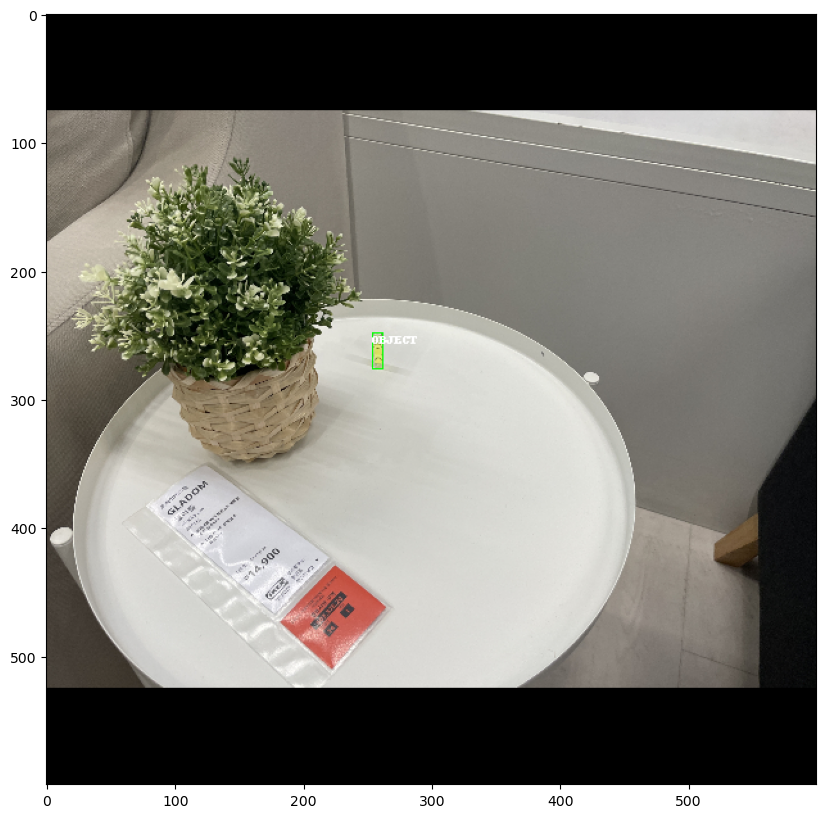

In [12]:
plt.figure(figsize=(10,10))
show(img, targets, labels,labelEncoder)

# RetinaNet Model 만들기

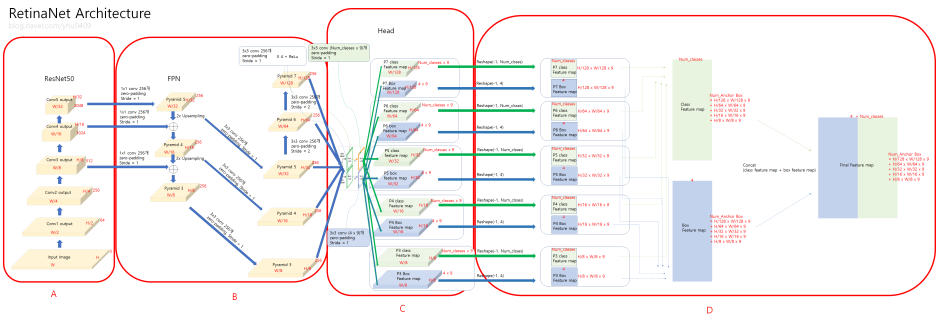

## AnchorBox

In [13]:
class AnchorBox:
    def __init__(self):
        self.anchor_areas = [32*32., 64*64., 128*128.,256*256, 512*512.] #Feature map에 대한 앵커 박스 넓이 순서대로 P3,P4,P5,P6,P7
        self.aspect_ratios = [1/2.,1/1.,2/1.] # 앵커박스의 종횡비
        self.scale_ratios = [1.,pow(2,1/3.),pow(2,2/3.)] #엥커박스의 다양한 3개의 scale을 주어 다른 3개의 넓이를 만든다.
        self.anchor_wh = self._get_anchor_wh() #5개의 Feature map 각각에 해당하는 9개의 앵커 박스를 생성한다. Feature map * (aspect_ratios * scale_ratios)
        
    def _get_anchor_wh(self):
        anchor_wh = []

        for s in self.anchor_areas:#각 feature map area 추출
            for ar in self.aspect_ratios: # 앵커박스의 종횡비 추출
                h = math.sqrt(s/ar) #앵커 박스의 높이 비율
                w = ar * h # 엥커박스의 넓이 비율

                for sr in self.scale_ratios: # 다양한 scale의 anchor box을 생성한다.
                    anchor_h = h*sr #앵커박스의 실제 높이
                    anchor_w = w*sr #앵커박스의 실제 넓이
                    anchor_wh.append([anchor_w, anchor_h])

        num_fms = len(self.anchor_areas)
        return torch.Tensor(anchor_wh).view(num_fms, -1, 2) # [5,9,2] [피쳐맵, 앵커박스의 개수, 앵커박스의 가로,높이]           
    
    def _get_anchor_boxes(self,input_size): # 피쳐맵의 모든 cell에 앵커박스를 할당한다.
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        num_fms = len(self.anchor_areas) #5
        fm_sizes = [ (input_size/pow(2.,i+3)).ceil() for i in range(num_fms)] # 각 피쳐맵 stride 만큼 입력 크기 축소
        
        boxes = []
        for i in range(num_fms): # p3 ~ p7
            fm_size = fm_sizes[i] # n번째 피쳐맵 크기 추출 
            grid_size = input_size / fm_size #gride size 생성

            fm_w, fm_h = int(fm_size[0]), int(fm_size[1])
            xy = self._meshgrid(fm_w, fm_h) + 0.5 #[fm_h * fm_w, 2] 피쳐맵 cell index 생성
            xy = (xy*grid_size).view(fm_h, fm_w, 1, 2).expand(fm_h, fm_w, 9, 2) # anchor 박스 좌표
            
            wh = self.anchor_wh[i].view(1,1,9,2).expand(fm_h, fm_w, 9, 2) # anchor 박스 높이와 너비
            box = torch.cat([xy,wh],3) # [x,y,w,h]
            boxes.append(box.view(-1,4))
        return torch.cat(boxes, 0)
    
    def _meshgrid(self, x, y):
        a = torch.arange(0,x)
        b = torch.arange(0,y)
        xx = a.repeat(y).view(-1,1)
        yy = b.view(-1,1).repeat(1,x).view(-1,1)
        
        return torch.cat([xx,yy],1)

### Anchor Box예시

사이즈 600 일때의, anchorbox 제시

In [14]:
anchorbox = AnchorBox()._get_anchor_boxes(600)
print(anchorbox)

tensor([[   4.0000,    4.0000,   22.6274,   45.2548],
        [   4.0000,    4.0000,   28.5088,   57.0175],
        [   4.0000,    4.0000,   35.9188,   71.8376],
        ...,
        [ 540.0000,  540.0000,  724.0773,  362.0387],
        [ 540.0000,  540.0000,  912.2803,  456.1401],
        [ 540.0000,  540.0000, 1149.4011,  574.7006]])


### Label Encoder

In [15]:
class DataEncoder:

    # 피쳐맵의 각 셀에 anchor 박스 생성하고, positive와 negative 할당
    def encode(self, boxes, labels, input_size, anchor_boxes):
        input_size = torch.Tensor([input_size, input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = anchor_boxes # 앵커 박스 생성
        boxes = self._change_box_order(boxes, 'xyxy2xywh') # xyxy -> cxcywh

        ious = self._box_iou(anchor_boxes, boxes, order='xywh') # ground-truth와 anchor의 iou 계산
        max_ious, max_ids = ious.max(1) # 가장 높은 iou를 지닌 앵커 추출
        boxes = boxes[max_ids]

        # 앵커 박스와의 offset 계산
        loc_xy = (boxes[:,:2]-anchor_boxes[:,:2]) / anchor_boxes[:,2:]
        loc_wh = torch.log(boxes[:,2:]/anchor_boxes[:,2:])
        loc_targets = torch.cat([loc_xy, loc_wh], 1)

        # class 할당
        cls_targets = 1 + labels[max_ids]
        cls_targets[max_ious<0.5] = 0 # iou < 0.5 anchor는 negative
        ignore = (max_ious>0.4) & (max_ious<0.5) # [0.4,0.5] 는 무시
        cls_targets[ignore] = -1
        return loc_targets, cls_targets
    
    # x1,y1,x2,y2 <-> cx,cy,w,h
    def _change_box_order(self, boxes, order):
        assert order in ['xyxy2xywh','xywh2xyxy']
        boxes = np.array(boxes)
        a = boxes[:,:2]
        b = boxes[:,2:]
        a, b = torch.Tensor(a), torch.Tensor(b)
        if order == 'xyxy2xywh':
            return torch.cat([(a+b)/2,b-a+1],1) # xywh
        return torch.cat([a-b/2, a+b/2],1) # xyxy

    # 두 박스의 iou 계산
    def _box_iou(self, box1, box2, order='xyxy'):
        if order == 'xywh':
            box1 = self._change_box_order(box1, 'xywh2xyxy')
            box2 = self._change_box_order(box2, 'xywh2xyxy')
        
        N = box1.size(0)
        M = box2.size(0)

        lt = torch.max(box1[:,None,:2], box2[:,:2])
        rb = torch.min(box1[:,None,2:], box2[:,2:])

        wh = (rb-lt+1).clamp(min=0)
        inter = wh[:,:,0] * wh[:,:,1]

        area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)
        area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)
        iou = inter / (area1[:,None] + area2 - inter)
        return iou
    
    # encode된 값을 원래대로 복구 및 nms 진행
    def decode(self,loc_preds, cls_preds, input_size):
        cls_thresh = 0.5
        nms_thresh = 0.5

        input_size = torch.Tensor([input_size,input_size]) if isinstance(input_size, int) else torch.Tensor(input_size)
        anchor_boxes = self._get_anchor_boxes(input_size) # 앵커 박스 생성

        loc_xy = loc_preds[:,:2] # 결과값 offset 추출
        loc_wh = loc_preds[:,2:]

        xy = loc_xy * anchor_boxes[:,2:] + anchor_boxes[:,:2] # offset + anchor
        wh = loc_wh.exp() * anchor_boxes[:,2:]
        boxes = torch.cat([xy-wh/2, xy+wh/2], 1)

        score, labels = cls_preds.sigmoid().max(1)
        ids = score > cls_thresh
        ids = ids.nonzero().squeeze()
        keep = self._box_nms(boxes[ids], score[ids], threshold=nms_thresh) # nms
        return boxes[ids][keep], labels[ids][keep]
    
    # nms
    def _box_nms(self, bboxes, scores, threshold=0.5, mode='union'):
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]

        areas = (x2-x1+1) * (y2-y1+1)
        _, order = scores.sort(0, descending=True) # confidence 순 정렬
        keep = []
        while order.numel() > 0:
            if order.numel() == 1:
                keep.append(order.data)
                break
            i = order[0] # confidence 가장 높은 anchor 추출
            keep.append(i) # 최종 detection에 저장

            xx1 = x1[order[1:]].clamp(min=x1[i])
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])

            w = (xx2-xx1+1).clamp(min=0)
            h = (yy2-yy1+1).clamp(min=0)
            inter = w*h

            if mode == 'union':
                ovr = inter / (areas[i] + areas[order[1:]] - inter)
            elif mode == 'min':
                ovr = inter / areas[order[1:]].clamp(max=areas[i])
            else:
                raise TypeError('Unknown nms mode: %s.' % mode)

            ids = (ovr<=threshold).nonzero().squeeze()
            if ids.numel() == 0:
                break
            order = order[ids+1]
        return torch.LongTensor(keep)

## DataLoader 

### DataLoader coolate_fn 정의

In [16]:
def collate_fn(batch):
    encoder = DataEncoder()
    imgs = [x[0] for x in batch]
    boxes = [torch.Tensor(x[1]) for x in batch]
    labels = [torch.Tensor(x[2]) for x in batch]
    h,w = 600, 600
    num_imgs = len(imgs)
    inputs = torch.zeros(num_imgs, 3, h, w)

    loc_targets = []
    cls_targets = []
    for i in range(num_imgs):
        inputs[i] = imgs[i]
        loc_target, cls_target = encoder.encode(boxes=boxes[i], labels=labels[i], input_size=(w,h),anchor_boxes= anchorbox)
        loc_targets.append(loc_target)
        cls_targets.append(cls_target)
    return inputs, torch.stack(loc_targets), torch.stack(cls_targets) 

### DataLoader 사용하여 batch 설정
batch = 4

In [17]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)

## ResNet
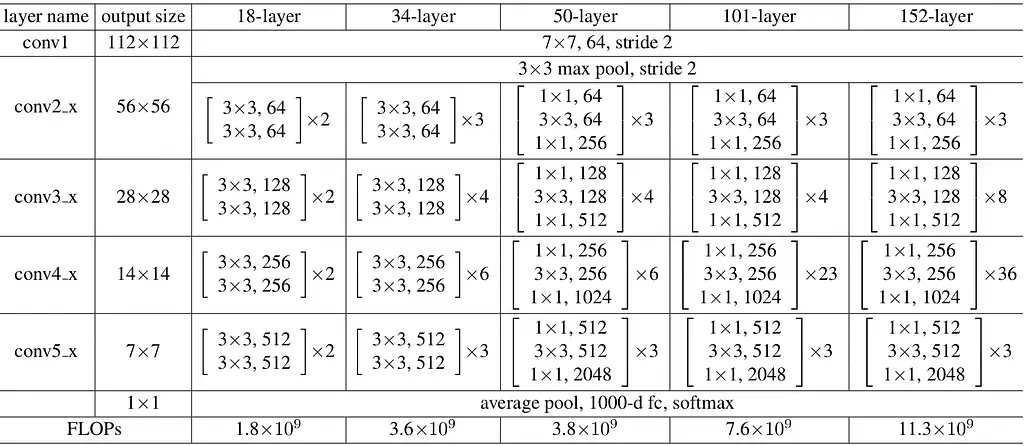

### Bottleneck
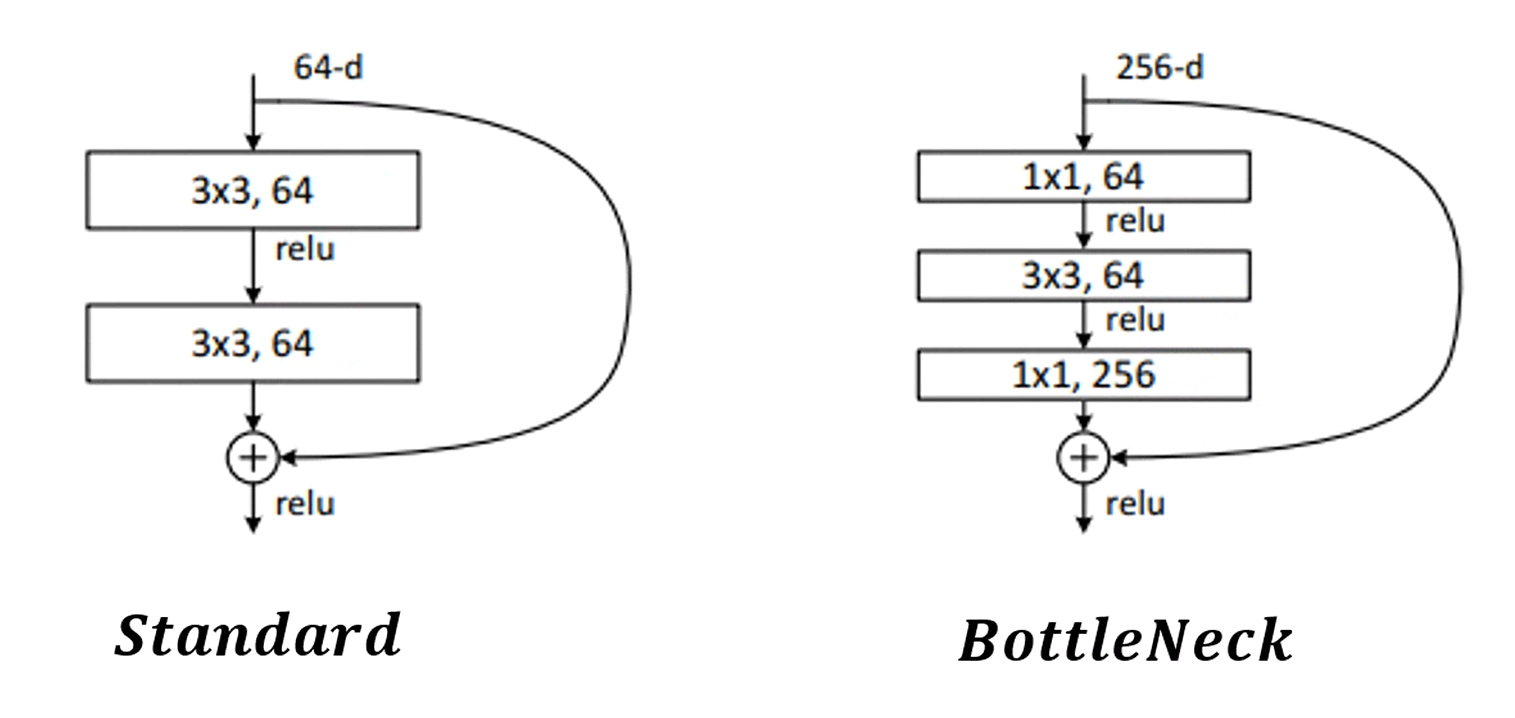

In [18]:
class Bottleneck(nn.Module):
    expand = 4

    def __init__(self, in_channels, inner_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_channels, 1, stride=1, padding=0, bias=False) # 1x1 kernel
        self.bn1 = nn.BatchNorm2d(inner_channels)
        self.conv2 = nn.Conv2d(inner_channels, inner_channels, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(inner_channels)
        self.conv3 = nn.Conv2d(inner_channels, inner_channels*self.expand, 1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(inner_channels*self.expand)
        self.relu = nn.ReLU()

        self.downsample = nn.Sequential()

        if stride != 1 or in_channels != inner_channels*self.expand:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, inner_channels*self.expand, 1, stride=stride, bias=False),
                nn.BatchNorm2d(inner_channels*self.expand)
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.bn1(self.conv1(x)))
        output = self.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))
        output = self.relu(output + self.downsample(x))

        return output

## FPN (Feature Pyramid Network) + RESNET

In [19]:
class FPN(nn.Module):
    def __init__(self, num_blocks):
        super(FPN, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False) # 300X 300
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1) # 150x150 모든 RESNET SIZE에서 고정

        # Bottom-up layers and ResNet.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)  # c2, 150x150
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)  # c3 75x75
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2) # c4 38x38
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2) # c5
        
        self.conv6 = nn.Conv2d(2048, 256, 3, stride=2, padding=1)    # p6
        self.conv7 = nn.Sequential(                                  # p7
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=2, padding=1)
        )

        # Lateral layers
        self.lateral_1 = nn.Conv2d(2048, 256, 1, stride=1, padding=0)
        self.lateral_2 = nn.Conv2d(1024, 256, 1, stride=1, padding=0)
        self.lateral_3 = nn.Conv2d(512, 256, 1, stride=1, padding=0)

        # Top-down layers
        self.top_down_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.top_down_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.upsample_1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.upsample_2 = nn.Upsample(size=(75,75), mode='bilinear', align_corners=False) # size=(75,75)를 지정해야 합니다.

    def forward(self, x):
        # Feature extractor(ResNet)
        c1 = self.relu(self.bn1(self.conv1(x)))
        c1 = self.maxpool(c1)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        # FPN
        p6 = self.conv6(c5)
        p7 = self.conv7(p6)
        p5 = self.lateral_1(c5)
        p4 = self.top_down_1(self.upsample_1(p5) + self.lateral_2(c4))
        p3 = self.top_down_2(self.upsample_2(p4) + self.lateral_3(c3))

        return p3, p4, p5, p6, p7

    def _make_layer(self, inner_channels, num_block, stride):
        strides = [stride] + [1] * (num_block-1)
        layers = []
        for stride in strides:
            layers.append(Bottleneck(self.in_channels, inner_channels, stride=stride))
            self.in_channels = inner_channels * Bottleneck.expand
        return nn.Sequential(*layers)

def FPN50(): # ResNet-50
    return FPN([3,4,6,3])

## RetinaNet 모델 구현

In [20]:
class RetinaNet(nn.Module):
    num_anchors = 9

    def __init__(self, num_classes=24):
        super().__init__()
        self.fpn = FPN50()
        self.num_classes = num_classes
        self.loc_head = self._make_head(self.num_anchors*4) # 바운딩 박스 좌표 예측
        self.cls_head = self._make_head(self.num_anchors*self.num_classes) # 바운딩 박스 클래스 예측

    def forward(self, x):
        # p3: batch, channels, H, W
        fms = self.fpn(x) # p3, p4, p5, p6, p7
        loc_preds = []
        cls_preds = []
        for fm in fms: # fpn 출력값에 classifier 추가
            loc_pred = self.loc_head(fm)
            cls_pred = self.cls_head(fm)
            
            loc_pred = loc_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,4)  # [N, 9*4,H,W] -> [N,H,W, 9*4] -> [N,H*W*9, 4]
            cls_pred = cls_pred.permute(0,2,3,1).contiguous().view(x.size(0),-1,self.num_classes) # [N,9*20,H,W] -> [N,H,W,9*20] -> [N,H*W*9,20]
            loc_preds.append(loc_pred)
            cls_preds.append(cls_pred)
        return torch.cat(loc_preds,1), torch.cat(cls_preds,1)

    def _make_head(self, out_channels): # 예측을 수행하는 Layer 생성
        layers = []
        for _ in range(4):
            layers.append(nn.Conv2d(256,256,3, stride=1, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.Conv2d(256, out_channels, 3, stride=1, padding=1)) # (batch,9*4,H,W) or (batch,9*20,H,W) 
        return nn.Sequential(*layers)

    def freeze_bn(self): # pre-trained model을 사용하므로, BN freeze
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

# Pretrain 된 BackBone 가중치 가지고오기

In [21]:
#!wget 'https://download.pytorch.org/models/resnet50-19c8e357.pth'

# 모델 초기화 (사전학습된 가중치 적용)

In [22]:
path2weight = 'resnet50-19c8e357.pth'
d = torch.load(path2weight)
fpn = FPN50()
dd = fpn.state_dict()

for k in d.keys():
    if not k.startswith('fc'): #full connect layer는 class 갯수가 다르기 때문에 새로 학습한다.
        dd[k] = d[k]

model = RetinaNet()

for m in model.modules():
    if isinstance(m, nn.Conv2d):
        init.normal_(m.weight, mean=0, std=0.01)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
pi = 0.01
init.constant_(model.cls_head[-1].bias, -math.log((1-pi)/pi))

model.fpn.load_state_dict(dd)  # fpn의 가중치를 사전 학습된 가중치로 변경
torch.save(model.state_dict(), 'model.pth') # 가중치 저장

# one-hot-embedding

In [23]:
def one_hot_embedding(labels, num_classes):
    # labels: class labels, sized [N,]
    # num_classes: 클래스 수 24
    y = torch.eye(num_classes) # [24, 24]
    np_labels = np.array(labels)
    return y[np_labels]

# 손실함수 정의

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.num_classes = num_classes

    # alternative focal loss
    def focal_loss_alt(self, x, y):
        alpha = 0.25

        t = one_hot_embedding(y.data.cpu(), 1+self.num_classes)
        t = t[:,1:] # 배경 제외
        t = t.cuda()

        xt = x*(2*t-1) # xt = x if t > 0 else -x
        pt = (2*xt+1).sigmoid()

        w = alpha*t + (1-alpha)*(1-t)
        loss = -w*pt.log() / 2
        return loss.sum()

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        # (loc_preds, loc_targets)와 (cls_preds, cls_targets) 사이의 loss 계산
        # loc_preds: [batch_size, #anchors, 4]
        # loc_targets: [batch_size, #anchors, 4]
        # cls_preds: [batch_size, #anchors, #classes]
        # cls_targets: [batch_size, #anchors]

        # loss = SmoothL1Loss(loc_preds, loc_targets) + FocalLoss(cls_preds, cls_targets)

        batch_size, num_boxes = cls_targets.size()
        pos = cls_targets > 0
        num_pos = pos.data.long().sum()

        # loc_loss = SmoothL1Loss(pos_loc_preds, pos_loc_targets)
        mask = pos.unsqueeze(2).expand_as(loc_preds) # [N, #anchors, 4], 객체가 존재하는 앵커박스 추출
        masked_loc_preds = loc_preds[mask].view(-1,4)      # [#pos, 4]
        masked_loc_targets = loc_targets[mask].view(-1, 4) # [#pos, 4]
        loc_loss = F.smooth_l1_loss(masked_loc_preds, masked_loc_targets, reduction='sum')

        # cls_loss = FocalLoss(loc_preds, loc_targets)
        pos_neg = cls_targets > -1 # ground truth가 할당되지 않은 anchor 삭제
        mask = pos_neg.unsqueeze(2).expand_as(cls_preds)
        masked_cls_preds = cls_preds[mask].view(-1, self.num_classes)
        cls_loss = self.focal_loss_alt(masked_cls_preds, cls_targets[pos_neg])

        # print('loc_loss: %.3f | cls_loss: %.3f' % (loc_loss.item(), cls_loss))
        loss = (loc_loss+cls_loss)/num_pos
        return loss

# 스케쥴러, loss 계산 함수 정의

In [25]:
loss_func = FocalLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=15)

# 현재 lr 계산
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# batch당 loss 계산
def loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt=None):
    loss_b = loss_func(loc_preds, loc_targets, cls_preds, cls_targets)
    
    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item()

# epoch당 loss 계산
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)

    for img, loc_targets, cls_targets in tqdm(dataset_dl):
        img, loc_targets, cls_targets = img.to(device), loc_targets.to(device), cls_targets.to(device)
        loc_preds, cls_preds = model(img)

        loss_b = loss_batch(loss_func, loc_preds, loc_targets, cls_preds, cls_targets, opt)
        
        running_loss += loss_b

        if sanity_check is True:
            break
    loss = running_loss / len_data
    return loss

# Train 함수 정의

In [26]:
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}

    best_loss = float('inf')
    torch.save(model.state_dict(),path2weights)
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr = {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(),path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)

        if current_lr != get_lr(opt):
            print('Loading best model weights')
            model.load_state_dict(torch.load(path2weight))

        run["train/loss"].append(train_loss)
        run["val/loss"].append(val_loss)
        
        print('train loss: %.6f, val loss: %.6f, time: %.4f min' %(train_loss, val_loss, (time.time()-start_time)/60))

    model.load_state_dict(torch.load(path2weight))
    return model, loss_history

# 파라미터 정의

In [27]:
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# 가중치 저장할 폴더 생성
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [28]:
import neptune.new as neptune

run = neptune.init_run(
    project="twogudak/RetinaNet",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDljNTU0ZC03NGM4LTQwNzEtYTBlNi0yYzE1OGZiNmE1MjkifQ==",
)  # your credentials


run["parameters"] = params_train
model=RetinaNet().to(device)
model = torch.nn.DataParallel(model, device_ids=list(range(NGPU)))
torch.multiprocessing.set_start_method('spawn')
model, loss_hist = train_val(model, params_train)

https://app.neptune.ai/twogudak/RetinaNet/e/RET-10
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/tmp/ipykernel_6893/2192666734.py:9: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` or `repr(object)` instead. For details, see https://docs.neptune.ai/setup/neptune-client_1-0_release_changes
  run["parameters"] = params_train


Epoch 0/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:38<00:00,  1.49s/it]


Copied best model weights!
train loss: 1198.685548, val loss: 1162.012652, time: 64.3554 min
Epoch 1/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:41<00:00,  1.50s/it]


Copied best model weights!
train loss: 1201.727881, val loss: 1160.067608, time: 128.3217 min
Epoch 2/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:39<00:00,  1.49s/it]


train loss: 1208.344153, val loss: 1173.673293, time: 192.1406 min
Epoch 3/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:41<00:00,  1.50s/it]


train loss: 1201.296783, val loss: 1183.440016, time: 256.1298 min
Epoch 4/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:37<00:00,  1.48s/it]


train loss: 1214.694591, val loss: 1181.518822, time: 319.8006 min
Epoch 5/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:40<00:00,  1.49s/it]


train loss: 1216.021045, val loss: 1194.866152, time: 383.7645 min
Epoch 6/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:40<00:00,  1.49s/it]


train loss: 1203.720467, val loss: 1174.485382, time: 447.5579 min
Epoch 7/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:40<00:00,  1.49s/it]


train loss: 1210.955040, val loss: 1163.567483, time: 511.4267 min
Epoch 8/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:39<00:00,  1.49s/it]


train loss: 1205.453744, val loss: 1197.494595, time: 575.1213 min
Epoch 9/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:40<00:00,  1.49s/it]


train loss: 1207.321632, val loss: 1200.992369, time: 638.8682 min
Epoch 10/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:38<00:00,  1.49s/it]


Copied best model weights!
train loss: 1209.158998, val loss: 1149.736180, time: 702.6495 min
Epoch 11/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:38<00:00,  1.49s/it]


train loss: 1206.153705, val loss: 1172.036354, time: 766.3139 min
Epoch 12/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:37<00:00,  1.48s/it]


train loss: 1208.046513, val loss: 1179.268279, time: 830.1245 min
Epoch 13/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:38<00:00,  1.49s/it]


train loss: 1208.522623, val loss: 1197.463555, time: 893.8641 min
Epoch 14/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:37<00:00,  1.48s/it]


train loss: 1210.289978, val loss: 1199.896066, time: 957.5387 min
Epoch 15/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:40<00:00,  1.49s/it]


train loss: 1202.834501, val loss: 1175.187475, time: 1021.3880 min
Epoch 16/99, current lr = 0.001


100%|█████████████████████████████████████████| 268/268 [06:38<00:00,  1.49s/it]


train loss: 1205.968957, val loss: 1176.290521, time: 1085.0008 min
Epoch 17/99, current lr = 0.001


 63%|████████████████████████▍              | 1271/2024 [35:49<20:20,  1.62s/it]Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/site-packages/websocket/_socket.py", line 108, in recv
    bytes_ = _recv()
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/site-packages/websocket/_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/ssl.py", line 1227, in recv
    return self.read(buflen)
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/ssl.py", line 1102, in read
    return self._sslobj.read(len)
TimeoutError: [Errno 110] Connection timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/user/anaconda3/envs/Junhyeok/lib/python3.9/site-packages/

train loss: 1205.937629, val loss: 1163.581793, time: 1148.7280 min
Epoch 18/99, current lr = 0.001


 27%|██████████▋                             | 539/2024 [15:18<42:09,  1.70s/it]


KeyboardInterrupt: 

In [29]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/twogudak/RetinaNet/e/RET-10


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()